# Flight Fare Prediction

The flight fare is based on demand and supply model with few restrictions on pricing from regulatory bodies. It is often perceived as unpredictable and recent dynamic pricing scheme added to the confusion. 

The objective is to create a machine learning model for predicting the flight fare based on historical data, which can be used for reference price for customers as well as airline service providers.


**Dataset:**

Dataset can be downloaded from kaggle using the below link:

    https://www.kaggle.com/nikhilmittal/flight-fare-prediction-mh/
    

In [1]:
#importing libraries
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing train data
# Since data is in form of excel file we have to use pandas read_excel to load the data.
# Make sure openpyxl and xlrd are already installed (pip install openpyxl; pip install xlrd) 
df=pd.read_excel('data/Data_Train.xlsx')

In [4]:
# Visualizing the dataframe
df.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882


In [5]:
# Exploring the features available in dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [6]:
# Statistical description of the data
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [7]:
df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [8]:
# Number of rows and columns 
df.shape

(10683, 11)

## Handling Missing values 

In [9]:
# Checking for Missing values 
# df.isna().any()
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

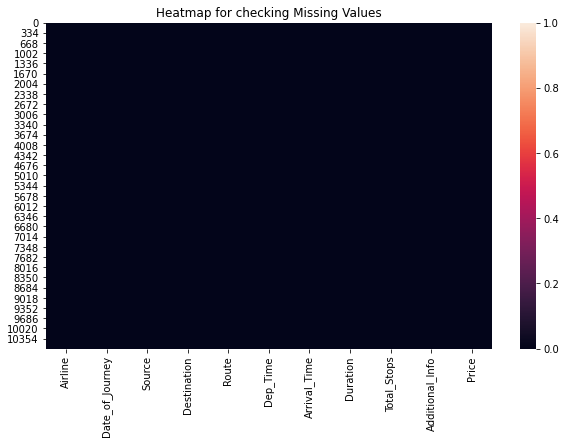

In [10]:
# Visualizing Missing values
plt.figure(figsize=(10,6))
sns.heatmap(df.isna())
plt.title('Heatmap for checking Missing Values')
plt.show()

In [11]:
df[df['Route'].isnull() | df['Total_Stops'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [12]:
df[df['Airline']=="Air India"][df['Source']=="Delhi"][df['Destination']=="Cochin"][df['Price']==7480][['Route','Total_Stops']].value_counts()

Route            Total_Stops
DEL → MAA → COK  1 stop         38
DEL → TRV → COK  1 stop          2
dtype: int64

**Either we can fill the Missing value with the most common value as below:**

```
    df['Route'].fillna("DEL → MAA → COK", inplace = True)
    df['Total_Stops'].fillna("1 stop", inplace = True)
```

**OR**

**We can just drop the row with missing value (we can choose this step as there is just 1 row)**


In [13]:
#drop the null values
df.dropna(inplace=True)

In [14]:
#finding the null values
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [15]:
# Number of rows and columns 
df.shape

(10682, 11)

## Handling Duplicate values

In [16]:
df.duplicated().any()

True

In [17]:
df[df.duplicated()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
683,Jet Airways,1/06/2019,Delhi,Cochin,DEL → NAG → BOM → COK,14:35,04:25 02 Jun,13h 50m,2 stops,No info,13376
1061,Air India,21/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,22:00,19:15 22 May,21h 15m,2 stops,No info,10231
1348,Air India,18/05/2019,Delhi,Cochin,DEL → HYD → BOM → COK,17:15,19:15 19 May,26h,2 stops,No info,12392
1418,Jet Airways,6/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,05:30,04:25 07 Jun,22h 55m,2 stops,In-flight meal not included,10368
1674,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,18:25,21:20,2h 55m,non-stop,No info,7303
...,...,...,...,...,...,...,...,...,...,...,...
10594,Jet Airways,27/06/2019,Delhi,Cochin,DEL → AMD → BOM → COK,23:05,12:35 28 Jun,13h 30m,2 stops,No info,12819
10616,Jet Airways,1/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,09:40,12:35 02 Jun,26h 55m,2 stops,No info,13014
10634,Jet Airways,6/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,09:40,12:35 07 Jun,26h 55m,2 stops,In-flight meal not included,11733
10672,Jet Airways,27/06/2019,Delhi,Cochin,DEL → AMD → BOM → COK,23:05,19:00 28 Jun,19h 55m,2 stops,In-flight meal not included,11150


In [18]:
df[df['Airline']=="Air India"][df['Source']=="Delhi"][df['Destination']=="Cochin"][df['Price']==10231][df['Date_of_Journey']=="2019-05-21"]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price


In [19]:
# dropping duplicate values
df.drop_duplicates(inplace=True)

In [20]:
df[df['Airline']=="Air India"][df['Source']=="Delhi"][df['Destination']=="Cochin"][df['Price']==10231][df['Date_of_Journey']=="2019-05-21"]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price


In [21]:
df.duplicated().any()

False

In [22]:
# Number of rows and columns 
df.shape

(10462, 11)

## Performing EDA and Feature Engineering

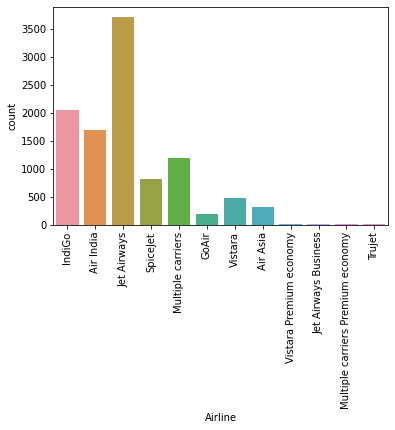

In [23]:
#Now lets check the count of the airlines in the visual graph
plot=plt.figure()
sns.countplot('Airline',data=df)
plt.xticks(rotation=90)
plt.show()

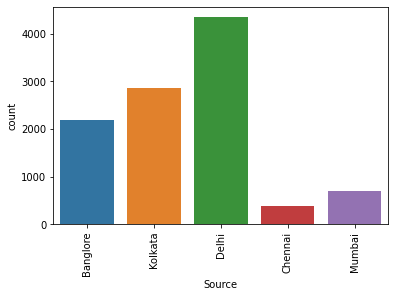

In [24]:
#Now lets check the count of the Source in the visual graph
plot=plt.figure()
sns.countplot('Source',data=df)
plt.xticks(rotation=90)
plt.show()

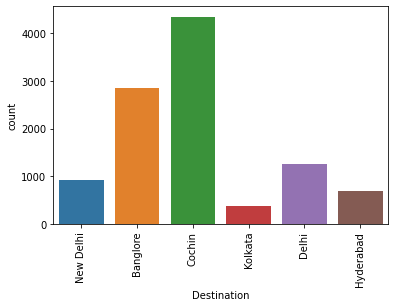

In [25]:
#Now lets check the count of the Destination in the visual graph
plot=plt.figure()
sns.countplot('Destination',data=df)
plt.xticks(rotation=90)
plt.show()

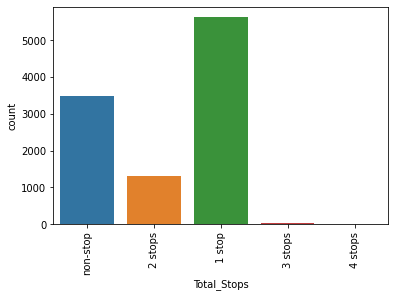

In [26]:
#Now lets check the count of the Total_Stops in the visual graph
plot=plt.figure()
sns.countplot('Total_Stops',data=df)
plt.xticks(rotation=90)
plt.show()

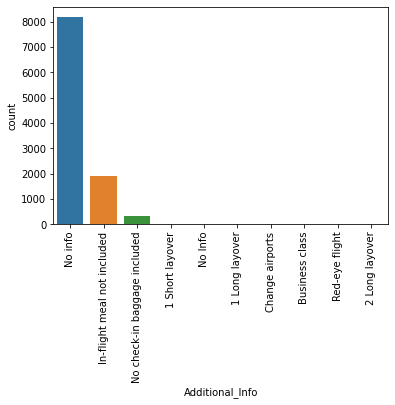

In [27]:
#Now lets check the count of the Additional_info in the visual graph
plot=plt.figure()
sns.countplot('Additional_Info',data=df)
plt.xticks(rotation=90)
plt.show()

In [28]:
#As we can see that there are two 'no_info' columns we combine them
df['Additional_Info']=df['Additional_Info'].str.replace('No info','No Info')

### Extracting useful Features from Date-Time Columns

In [29]:
df['Date_of_Journey']=pd.to_datetime(df['Date_of_Journey'])
df['Dep_Time']=pd.to_datetime(df['Dep_Time']).dt.time
df['Arrival_Time']=pd.to_datetime(df['Arrival_Time']).dt.time

In [30]:
#we are converting the flights day to find which day it is in the week and storing it in the weekday column
df['Journey_Weekday']=df[['Date_of_Journey']].apply(lambda x:x.dt.day_name())

<AxesSubplot:xlabel='Journey_Weekday', ylabel='Price'>

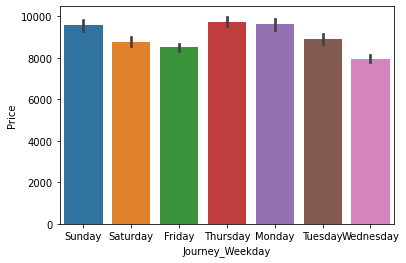

In [31]:
#now lets check the relation between weekday of the journey and the output price column
sns.barplot('Journey_Weekday','Price',data=df)

In [32]:
#we are converting the flights date to find which month it is and storing it in the month column
df["Journey_Month"] = df['Date_of_Journey'].map(lambda x: x.month_name())

<AxesSubplot:xlabel='Journey_Month', ylabel='Price'>

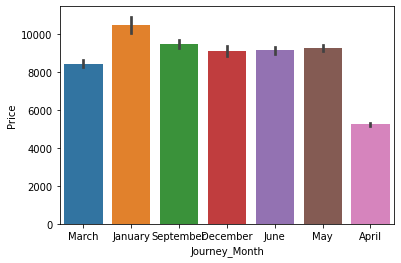

In [33]:
#now lets check the relation between month of journey and the output price column
sns.barplot('Journey_Month','Price',data=df)

In [34]:
#we are converting the flights day to find which day it is in the week and storing it in the weekday column
df['Journey_Day']=df[['Date_of_Journey']].apply(lambda x:x.dt.day)

<AxesSubplot:xlabel='Journey_Day', ylabel='Price'>

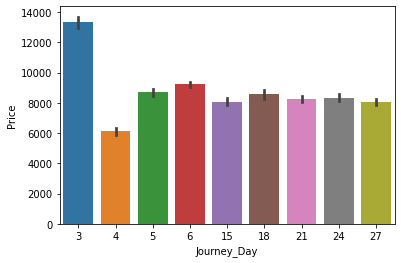

In [35]:
#now lets check the relation between day of the journey and the output price column
sns.barplot('Journey_Day','Price',data=df)

In [36]:
df['Date_of_Journey'].dt.year.value_counts()

2019    10462
Name: Date_of_Journey, dtype: int64

In [37]:
#we are taking the departure time hour column and converting it into a numeric
df['Dep_Hour']=df['Dep_Time'].apply(lambda x:x.hour)
df['Dep_Hour']=pd.to_numeric(df['Dep_Hour'])

<AxesSubplot:xlabel='Dep_Hour', ylabel='Price'>

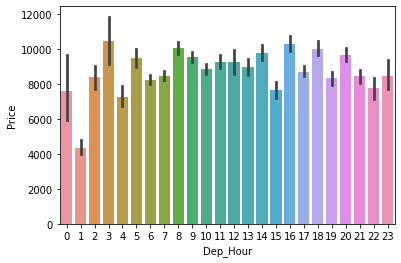

In [38]:
#now lets check the departure time hour relation with the output price column
sns.barplot('Dep_Hour','Price',data=df)

In [39]:
#we are taking the departure time minute column and converting it into a numeric
df['Dep_Min']=df['Dep_Time'].apply(lambda x:x.minute)
df['Dep_Min']=pd.to_numeric(df['Dep_Min'])

In [40]:
#we are taking the arrival time hour column and converting it into a numeric
df['Arrival_Hour']=df['Arrival_Time'].apply(lambda x:x.hour)
df['Arrival_Hour']=pd.to_numeric(df['Arrival_Hour'])

<AxesSubplot:xlabel='Arrival_Hour', ylabel='Price'>

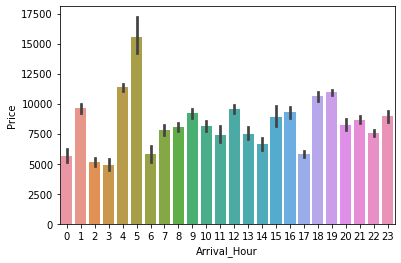

In [41]:
#now lets check the arrival time hour relation with the output price column
sns.barplot('Arrival_Hour','Price',data=df)

In [42]:
#we are taking the arrival time minute column and converting it into a numeric
df['Arrival_Min']=df['Arrival_Time'].apply(lambda x:x.minute)
df['Arrival_Min']=pd.to_numeric(df['Arrival_Min'])

### Extracting useful Features from special column "Routes"

In [43]:
df['Route1']=df['Route'].str.split('→').str[0]
df['Route2']=df['Route'].str.split('→').str[1]
df['Route3']=df['Route'].str.split('→').str[2]
df['Route4']=df['Route'].str.split('→').str[3]
df['Route5']=df['Route'].str.split('→').str[4]
for i in ['Route1','Route2','Route3','Route4','Route5']:
    df[i].fillna('None',inplace=True)

### Handling the unit of measurement 

In [44]:
#For the duration column which is in a hour and min format lets convert it into minutes using a equation 
df['Duration']=df['Duration'].str.replace('h','*60').str.replace(' ','+').str.replace('m','*1').apply(eval)
#now lets convert this column into a numeric
df['Duration']=pd.to_numeric(df['Duration'])

array([[<AxesSubplot:title={'center':'Duration'}>]], dtype=object)

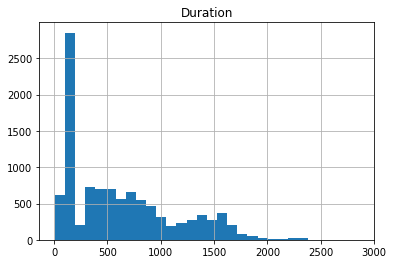

In [45]:
df.hist(column='Duration', bins = 30)

### Removing the irrelevant features

In [46]:
#Now lets remove the irrelevant features
df.drop(['Route','Dep_Time','Arrival_Time','Date_of_Journey'],axis=1,inplace=True)

In [47]:
df.head()

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info,Price,Journey_Weekday,Journey_Month,Journey_Day,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min,Route1,Route2,Route3,Route4,Route5
0,IndiGo,Banglore,New Delhi,170,non-stop,No Info,3897,Sunday,March,24,22,20,1,10,BLR,DEL,None,None,None
1,Air India,Kolkata,Banglore,445,2 stops,No Info,7662,Saturday,January,5,5,50,13,15,CCU,IXR,BBI,BLR,None
2,Jet Airways,Delhi,Cochin,1140,2 stops,No Info,13882,Friday,September,6,9,25,4,25,DEL,LKO,BOM,COK,None
3,IndiGo,Kolkata,Banglore,325,1 stop,No Info,6218,Thursday,December,5,18,5,23,30,CCU,NAG,BLR,None,None
4,IndiGo,Banglore,New Delhi,285,1 stop,No Info,13302,Thursday,January,3,16,50,21,35,BLR,NAG,DEL,None,None


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10462 entries, 0 to 10682
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10462 non-null  object
 1   Source           10462 non-null  object
 2   Destination      10462 non-null  object
 3   Duration         10462 non-null  int64 
 4   Total_Stops      10462 non-null  object
 5   Additional_Info  10462 non-null  object
 6   Price            10462 non-null  int64 
 7   Journey_Weekday  10462 non-null  object
 8   Journey_Month    10462 non-null  object
 9   Journey_Day      10462 non-null  int64 
 10  Dep_Hour         10462 non-null  int64 
 11  Dep_Min          10462 non-null  int64 
 12  Arrival_Hour     10462 non-null  int64 
 13  Arrival_Min      10462 non-null  int64 
 14  Route1           10462 non-null  object
 15  Route2           10462 non-null  object
 16  Route3           10462 non-null  object
 17  Route4           10462 non-null

## Handling Outliers

<AxesSubplot:>

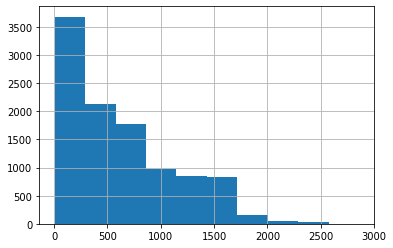

In [69]:
df['Duration'].hist()

<AxesSubplot:xlabel='Duration'>

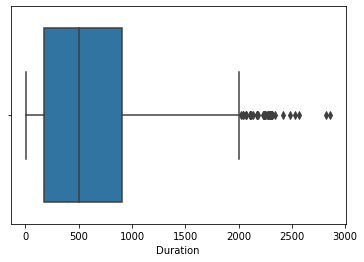

In [72]:
sns.boxplot(df["Duration"])

<AxesSubplot:>

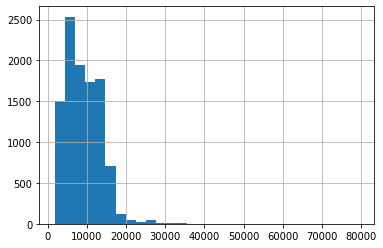

In [55]:
df['Price'].hist(bins=30)

<AxesSubplot:xlabel='Price'>

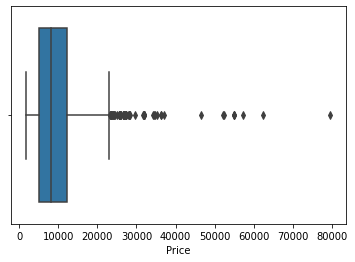

In [71]:
sns.boxplot(df["Price"])

In [70]:
def find_outlier_boundaries(data, variable, distance):
    """
    Calculates the boundaries outside which sit the outliers.
    
    distance passed as an argument, gives us the option to estimate 1.5 times or 3 times the IQR to calculate the boundaries.
    """
    IQR = data[variable].quantile(0.75) - data[variable].quantile(0.25)

    lower_boundary = data[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = data[variable].quantile(0.75) + (IQR * distance)

    return lower_boundary, upper_boundary

In [74]:
# find limits for frequency
price_lower_limit, price_upper_limit = find_outlier_boundaries(df, 'Price', 1.5)
price_lower_limit, price_upper_limit

(-5457.125, 23025.875)

In [76]:
# Now let's replace the outliers by the maximum and minimum limit
df['Price']= np.where(df['Price'] > price_upper_limit, price_upper_limit,
                       np.where(df['Price'] < price_lower_limit, price_lower_limit, df['Price']))

<AxesSubplot:>

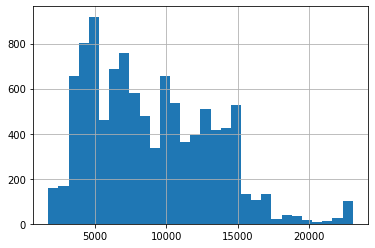

In [77]:
df['Price'].hist(bins=30)

<AxesSubplot:xlabel='Price'>

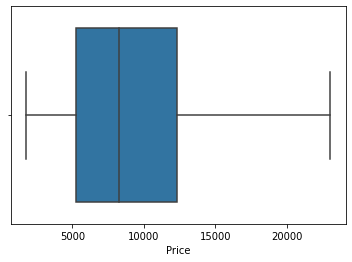

In [78]:
sns.boxplot(df["Price"])

In [79]:
# find limits for frequency
duration_lower_limit, duration_upper_limit = find_outlier_boundaries(df, 'Duration', 1.5)
duration_lower_limit, duration_upper_limit

(-940.0, 2020.0)

In [80]:
# Now let's replace the outliers by the maximum and minimum limit
df['Duration']= np.where(df['Duration'] > duration_upper_limit, duration_upper_limit,
                       np.where(df['Duration'] < duration_lower_limit, duration_lower_limit, df['Duration']))

<AxesSubplot:>

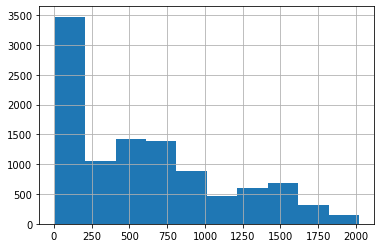

In [84]:
df['Duration'].hist()

<AxesSubplot:xlabel='Duration'>

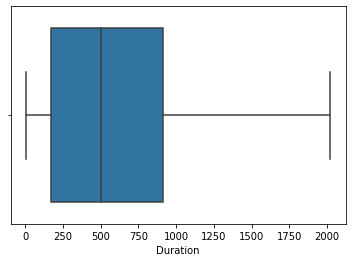

In [82]:
sns.boxplot(df["Duration"])

In [85]:
# Splitting the data in to two parts one is used to train the model and another is used to evaluate the model
X_train, X_test, y_train, y_test = train_test_split(df.drop('Price',axis=1), df['Price'], test_size=0.2, random_state=101)

# Predicting for test data file¶

In [49]:
test_df=pd.read_excel('data/Test_set.xlsx')

In [50]:
test_df.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included


In [51]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


In [52]:
test_df['Date_of_Journey']=pd.to_datetime(test_df['Date_of_Journey'])
test_df['Dep_Time']=pd.to_datetime(test_df['Dep_Time']).dt.time
test_df['Arrival_Time']=pd.to_datetime(test_df['Arrival_Time']).dt.time
test_df['Additional_Info']=test_df['Additional_Info'].str.replace('No info','No Info')
test_df['Journey_Weekday']=test_df[['Date_of_Journey']].apply(lambda x:x.dt.day_name())
test_df["Journey_Month"] = test_df['Date_of_Journey'].map(lambda x: x.month_name())
test_df['Journey_Day']=test_df[['Date_of_Journey']].apply(lambda x:x.dt.day)
test_df['Dep_Hour']=pd.to_numeric(test_df['Dep_Time'].apply(lambda x:x.hour))
test_df['Dep_Min']=pd.to_numeric(test_df['Dep_Time'].apply(lambda x:x.minute))
test_df['Arrival_Hour']=pd.to_numeric(test_df['Arrival_Time'].apply(lambda x:x.hour))
test_df['Arrival_Min']=pd.to_numeric(test_df['Arrival_Time'].apply(lambda x:x.minute))
test_df['Route1']=test_df['Route'].str.split('→').str[0]
test_df['Route2']=test_df['Route'].str.split('→').str[1]
test_df['Route3']=test_df['Route'].str.split('→').str[2]
test_df['Route4']=test_df['Route'].str.split('→').str[3]
test_df['Route5']=test_df['Route'].str.split('→').str[4]
for i in ['Route1','Route2','Route3','Route4','Route5']:
    test_df[i].fillna('None',inplace=True)
test_df['Duration']=test_df['Duration'].str.replace('h','*60').str.replace(' ','+').str.replace('m','*1').apply(eval)
test_df['Duration']=pd.to_numeric(test_df['Duration'])

test_df.drop(['Route','Dep_Time','Arrival_Time','Date_of_Journey'],axis=1,inplace=True)
#for i in var_mod:
#    test_df[i]=le.fit_transform(test_df[i])